In [2]:
# Colab was used for this notebook hence the library installs
%%capture
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

UsageError: Line magic function `%%capture` not found.


## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an insurance related problem (although ficticious data)
4. Build a `streamlit` app

## **The data**
HR data isn't easy to find given the nature of the data. However IBM has created [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around whether an employee left after 6 months which can be used. The features for each employee are...

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `


# **Libraries**

In [1]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [2]:
# Read and output the top 5 rows
ins_data = pd.read_csv("insurance.csv")
ins_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


156


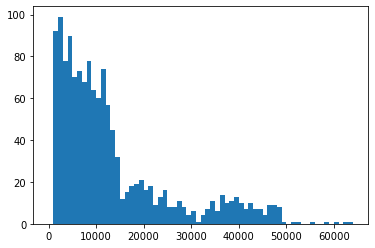

In [3]:
ins_data = pd.read_csv("insurance.csv")
from matplotlib import pyplot as plt
plt.hist(ins_data['charges'], bins=[1000*i for i in range (65)])
ins_data['charges'].describe()
def transform(x):
    if x<5000: return 0 # First"Peak"
    if x<16000: return 1 # Second Peak
    if x<31000: return 2 # Thrid Peak
    return 3
print(len(ins_data[ins_data["charges"]>31000]))
ins_data["charges"]=ins_data["charges"].map(transform)

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [4]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


In [5]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(ins_data.drop("charges", axis = 1), ins_data["charges"], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["charges"] = target_train
test["charges"] = target_test

In [6]:
# Run pycaret setup
setup(data = train, 
      target = target, 
      test_data = test,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True,
      verbose = False)

(25      1
 336     1
 47      0
 106     0
 1269    1
        ..
 1095    0
 1130    1
 1294    1
 860     3
 1126    1
 Name: charges, Length: 802, dtype: int64,
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 Pipe

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [7]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8778,0.9376,0.8433,0.8807,0.8727,0.8154,0.8190,0.2480
gbc,Gradient Boosting Classifier,0.8715,0.9340,0.8354,0.8734,0.8660,0.8054,0.8089,0.1690
lr,Logistic Regression,0.8641,0.9184,0.8133,0.8678,0.8563,0.7924,0.7979,0.6300
lightgbm,Light Gradient Boosting Machine,0.8641,0.9339,0.8289,0.8659,0.8587,0.7950,0.7982,0.0790
ridge,Ridge Classifier,0.8504,0.0000,0.7909,0.8600,0.8322,0.7723,0.7804,0.0230
et,Extra Trees Classifier,0.8404,0.9294,0.8031,0.8414,0.8380,0.7602,0.7624,0.1270
lda,Linear Discriminant Analysis,0.8392,0.9222,0.7714,0.8444,0.8131,0.7560,0.7664,0.0140
dt,Decision Tree Classifier,0.8142,0.8655,0.7977,0.8229,0.8148,0.7247,0.7269,0.0230
ada,Ada Boost Classifier,0.7619,0.8576,0.6504,0.6943,0.7176,0.6379,0.6526,0.0950
nb,Naive Bayes,0.7443,0.9201,0.7422,0.7894,0.7368,0.6294,0.6525,0.0160


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=948, verbose=0,
                       warm_start=False)

So `Logistic Regression` is looking promising for `AUC` but `Recall` is not high, regardless I'll build a model on this. As shown below each fold's metrics are shown and the average from them.

In [8]:
rf = create_model("rf") # Create logistic regression model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9012,0.9811,0.8920,0.8992,0.8999,0.8524,0.8526
1,0.8519,0.9258,0.8386,0.8504,0.8508,0.7800,0.7802
2,0.8500,0.9299,0.8106,0.8431,0.8394,0.7720,0.7757
3,0.9000,0.9491,0.8638,0.9030,0.8977,0.8470,0.8500
4,0.9000,0.9286,0.8549,0.8997,0.8956,0.8494,0.8521
5,0.9000,0.9447,0.8585,0.9113,0.8978,0.8454,0.8517
6,0.8250,0.8786,0.7869,0.8187,0.8172,0.7376,0.7407
7,0.9125,0.9763,0.8793,0.9137,0.9110,0.8670,0.8686
8,0.8750,0.9414,0.8348,0.8853,0.8737,0.8132,0.8178
9,0.8625,0.9205,0.8136,0.8823,0.8435,0.7897,0.8002


Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.

# **Generating synthetic data** 
# **NAIVE GENERATING**
# **CTGAN**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` [Bayesian Tuning and Bandits](https://github.com/MLBazaar/BTB) which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [9]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(ins_data["bmi"])
max_bmi = max(ins_data["bmi"])
print(min_bmi,max_bmi)

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(ins_data["charges"])
max_charges = max(ins_data["charges"])
print(min_charges,max_charges)

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

15.96 53.13
0 3


In [10]:
import time
best_score = 0 # Keep track of best score
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left
ST=time.time()
## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    #proposal = tuner.propose(1)
  
    # Create the CopulaGAN -> GAussianCopu;a
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    
    # Fit the CTGAN
    model.fit(real)
    metadata = model.get_metadata()
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        #best_params = proposal
        best_score = score
  


## TRAINING LOOP END ##
ED=time.time()
print((ED-ST)/60,"minutes")

1
0.5192644798488097
2
0.549257513364863
3
0.5749121621647875
4
0.5734098010198216
5
0.4149172480743682
6
0.524585166447485
7
0.5633333836695493
8
0.5012760414113712
9
0.4815495572223474
10
0.5588507729330031
11
0.5267310162505743
12
0.5287776870038309
13
0.5796400814649372
14
0.4648438599198303
15
0.5150419889317431
16
0.4882402305809749
17
0.5332914480408937
18
0.5052308974596242
19
0.5466715959767615
20
0.5487583273475443
21
0.5745920532332568
22
0.5734245117960934
23
0.5383477435984118
24
0.5048248389897803
25
0.5502601323093563
26
0.596593873670176
27
0.5313430000875393
28
0.5206874934336692
29
0.5455818995805463
30
0.5298406355409271
17.92259786128998 minutes


In [11]:
metadata

Table(name=None, field_names=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])

In [12]:
bmi=synth_data["bmi"]

In [13]:
bmi.describe()

count    600.000000
mean      30.227849
std        8.443489
min       15.984825
25%       22.738186
50%       32.186053
75%       36.667935
max       52.021027
Name: bmi, dtype: float64

In [14]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.617725,0.072969,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.636048,0.636048,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.401288,0.401288,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-2.982505,0.048223,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.971888,0.971888,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.809576,0.809576,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.879352,0.879352,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.591890,0.591890,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.991406,0.991406,0.0,1.0,MAXIMIZE


In [15]:
score['normalized_score'].mean()

0.600293280056525

In [16]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = True)
score

0.5988170697831237

In [17]:
print(max(scores))
print(min(scores))

0.596593873670176
0.4149172480743682


In [18]:
model.save('best_copula.pkl')

In [19]:
synth_data.to_csv("ins_synth_data_classifier_CTGANImb.csv", index = False)

So after 75 loops the overall score is 0.81 (this score is between 0 and 1) for 600 synthetic examples of Attrition = "Yes" so it's not too bad.

```
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}
```

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [20]:
# Load synth data in
synth_data = pd.read_csv("ins_synth_data_classifier_CTGANImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data])

In [21]:
synth_data

,age,sex,bmi,children,smoker,region,charges
0,62,female,34.847417,1,no,northeast,0
1,61,female,37.425887,0,no,southwest,1
2,68,female,18.170885,0,no,northwest,1
3,36,female,32.402729,0,no,southwest,0
4,75,female,36.670050,1,no,southwest,0
...,...,...,...,...,...,...,...
595,69,male,31.078567,0,no,northeast,2
596,21,female,37.632573,1,no,northeast,0
597,41,male,24.916926,0,no,southwest,2
598,71,female,33.386479,0,no,southeast,0


In [22]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


In [23]:
ord_feats = {"children" : list("012345")}

The ratio of the synthetic data of charge >14000 is 0.0000


(array([226., 280.,  60.,  34.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

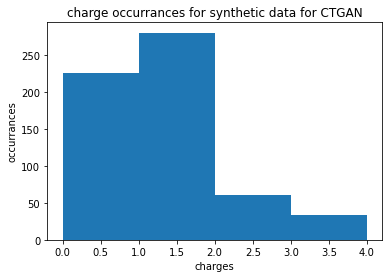

In [24]:
from matplotlib import pyplot as plt
#num_bins = 20
#group = [1000*i for i in range(13,65)]
#plt.hist(synth_data["charges"], group)
total01=len(synth_data["charges"])
ans01=[]
for i in range(0,4):
    num=len(synth_data["charges"][synth_data["charges"]==i])
    ans01.append(num/total01)
ans01=np.array(ans01)
print("The ratio of the synthetic data of charge >14000 is %.4f"%sum(ans01[14:]))
plt.title("charge occurrances for synthetic data for CTGAN")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(synth_data["charges"],bins=[i for i in range (5)])

The ratio of the original data of charge >14000 is 0.0000


(array([359., 633., 190., 156.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

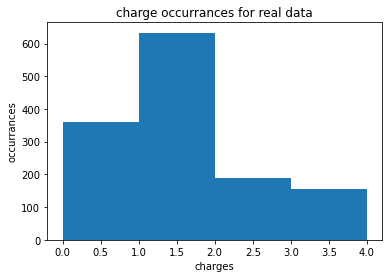

In [25]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total02=len(ins_data["charges"])
ans02 = []
for i in range(4):
    num=len(ins_data["charges"][ins_data["charges"]==i])
    ans02.append(num/total02)
ans02=np.array(ans02)
print("The ratio of the original data of charge >14000 is %.4f"%sum(ans02[14:]))
plt.title("charge occurrances for real data")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(ins_data["charges"],bins=[i for i in range (5)])

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [26]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = target, 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(25      1
 336     1
 47      0
 106     0
 1269    1
        ..
 595     2
 596     0
 597     2
 598     0
 599     0
 Name: charges, Length: 1402, dtype: int64,
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 Pip

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [27]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6374,0.7459,0.5699,0.6298,0.6237,0.4302,0.4355,0.1560
rf,Random Forest Classifier,0.6067,0.7368,0.5365,0.5942,0.5941,0.3829,0.3861,0.1480
lightgbm,Light Gradient Boosting Machine,0.5960,0.7267,0.5261,0.5880,0.5839,0.3688,0.3732,0.0820
nb,Naive Bayes,0.5867,0.7232,0.5379,0.5824,0.5746,0.3753,0.3780,0.0150
lda,Linear Discriminant Analysis,0.5846,0.7234,0.5349,0.5844,0.5614,0.3691,0.3762,0.0130
lr,Logistic Regression,0.5732,0.7184,0.4638,0.5492,0.5356,0.3108,0.3219,0.6830
ada,Ada Boost Classifier,0.5710,0.6982,0.4515,0.5708,0.5473,0.3173,0.3247,0.0390
et,Extra Trees Classifier,0.5640,0.7113,0.4825,0.5513,0.5531,0.3233,0.3254,0.1300
ridge,Ridge Classifier,0.5604,0.0000,0.4045,0.4910,0.5056,0.2683,0.2800,0.0130
dt,Decision Tree Classifier,0.5170,0.6358,0.4554,0.5205,0.5169,0.2697,0.2705,0.0120


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=365, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [28]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8440,0.9379,0.7792,0.8490,0.8407,0.7546,0.7594
1,0.8440,0.9263,0.7852,0.8603,0.8336,0.7525,0.7610
2,0.8214,0.9247,0.7096,0.8461,0.8117,0.7110,0.7226
3,0.8429,0.9252,0.8024,0.8438,0.8408,0.7557,0.7570
4,0.8143,0.8572,0.7412,0.8145,0.8035,0.7048,0.7116
5,0.5786,0.7425,0.5934,0.5413,0.5428,0.3292,0.3447
6,0.4071,0.6138,0.4097,0.4124,0.4058,0.1177,0.1183
7,0.4071,0.4955,0.3349,0.3760,0.3857,0.0793,0.0808
8,0.3857,0.5081,0.2564,0.3573,0.3652,0.0151,0.0155
9,0.4286,0.5283,0.2873,0.3973,0.4072,0.0818,0.0836


# **SECOND TRIAL**, NORMALIZED, CTGAN

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [29]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 5000)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_metadata()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.5450754958715591
2
0.5780719002481698
3
0.5357733115107489
4
0.5643807301535619
5
0.5309612880429455
6
0.536960837097099
7
0.5353309475298091
8
0.5671001645339365
9
0.6073131673851078
10
0.5399504947297366
11
0.5379338700550209
12
0.5632371945430912
13
0.5699052185296594
14
0.5481071750878388
15
0.4775854277197403
16
0.534633772039242
17
0.4773862749916032
18
0.5696501497953109
19
0.5426168104240008
20
0.5340365868394621
21
0.4722779723726433
22
0.5988677273006661
23
0.4738746561926994
24
0.48744775095485576
25
0.5440357798624722
26
0.5247013823543134
27
0.5112363755260554
28
0.5235291540118142
29
0.545666434363476
30
0.5004019176456657
time used: 21.159 mins


In [30]:
best_data

,age,sex,bmi,children,smoker,region,charges
0,73,male,33.628422,1,yes,southwest,1
4,18,female,29.985371,2,yes,southeast,2
6,18,female,40.316019,3,yes,southwest,2
8,37,male,38.545165,0,yes,northeast,1
9,61,male,17.755095,2,yes,southwest,0
...,...,...,...,...,...,...,...
8980,23,female,35.845947,2,no,northwest,2
8981,29,female,32.349811,0,yes,northwest,0
8982,45,male,44.563008,2,no,southwest,0
8984,22,female,25.662498,0,yes,southwest,0


In [31]:
best_distributions

Table(name=None, field_names=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])

In [32]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.707685,0.066691,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.831139,0.831139,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.300058,0.300058,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-905.491640,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.924868,0.924868,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.870074,0.870074,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.903544,0.903544,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.585070,0.585070,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.975906,0.975906,0.0,1.0,MAXIMIZE


In [33]:
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part.sample(n=min(max(0,350-orig_size),len(synth_part)))
    print(len(generate))
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

139
0
228
261


,age,sex,bmi,children,smoker,region,charges
2166,71,female,29.696412,1,no,northwest,2
2737,44,male,28.950625,3,no,southwest,0
5520,33,female,43.035992,1,no,northeast,2
2649,42,male,43.494121,0,yes,northeast,3
6482,43,female,30.208926,0,yes,northwest,2
...,...,...,...,...,...,...,...
1730,59,female,40.353056,0,yes,northwest,2
1305,18,male,36.265605,1,yes,southwest,3
6717,27,female,46.480157,2,no,southeast,2
8190,49,male,29.063243,0,no,southwest,3


In [34]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.5434023742678463

In [35]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6073131673851078


In [36]:
print(max(scores))
print(min(scores))

0.6073131673851078
0.4722779723726433


In [37]:
model.save('best_copula.pkl')

In [38]:
synth.to_csv("ins_synth_norm_CTGANImb.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [39]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_norm_CTGANImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [40]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,1
336,60,male,25.740000,0,no,southeast,1
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
623,24,male,23.484833,2,no,southeast,3
624,43,female,37.145959,1,no,southwest,3
625,19,male,26.646479,4,no,northeast,3
626,30,male,16.730939,1,yes,southwest,3


In [41]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1430, 7)
Testing size (real: (536, 7)


Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [42]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(25      1
 336     1
 47      0
 106     0
 1269    1
        ..
 623     3
 624     3
 625     3
 626     3
 627     3
 Name: charges, Length: 1430, dtype: int64,
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 Pip

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [43]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5559,0.7601,0.5502,0.5371,0.5283,0.4054,0.4139,0.1990
nb,Naive Bayes,0.5217,0.7253,0.5128,0.4913,0.4638,0.3572,0.3801,0.0170
ridge,Ridge Classifier,0.5210,0.0000,0.5138,0.4974,0.4637,0.3572,0.3780,0.0150
lr,Logistic Regression,0.5196,0.7275,0.5128,0.4988,0.4701,0.3559,0.3742,0.8700
lda,Linear Discriminant Analysis,0.5189,0.7282,0.5122,0.4956,0.4666,0.3548,0.3736,0.0160
rf,Random Forest Classifier,0.5147,0.7401,0.5102,0.4955,0.4955,0.3511,0.3553,0.1630
lightgbm,Light Gradient Boosting Machine,0.5021,0.7376,0.4985,0.4906,0.4891,0.3349,0.3382,0.1020
ada,Ada Boost Classifier,0.4867,0.7164,0.4811,0.4602,0.4493,0.3128,0.3244,0.0470
qda,Quadratic Discriminant Analysis,0.4846,0.6851,0.4767,0.4799,0.4445,0.3084,0.3232,0.0170
et,Extra Trees Classifier,0.4629,0.7087,0.4594,0.4526,0.4529,0.2826,0.2842,0.1520


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3150, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

# **SECOND TRIAL**, CTGAN, NORMALIZED, CF

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [44]:
train

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720,3,no,southeast,1
336,60,male,25.740,0,no,southeast,1
47,28,female,34.770,0,no,northwest,0
106,19,female,28.400,1,no,southwest,0
1269,45,male,27.500,3,no,southwest,1
...,...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast,0
1130,39,female,23.870,5,no,southeast,1
1294,58,male,25.175,0,no,northeast,1
860,37,female,47.600,2,yes,southwest,3


In [45]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint],
                 field_transformers = {k:"categorical_fuzzy" for k in ["sex", "smoker", "region"]})
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_metadata()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.4875208244304567
2
0.6060308611253685
3
0.6673986563819909
4
0.47925330714734365
5
0.46546722428693765
6
0.4964778149407654
7
0.49375429966419243
8
0.49627655944918014
9
0.5097140556064379
10
0.5146576209655892
11
0.47198014890551904
12
0.5312352381558147
13
0.5528210881103044
14
0.528719477309372
15
0.640750669579345
16
0.5505519435440978
17
0.5445485096398351
18
0.530603428952571
19
0.632069383418546
20
0.5540439690829686
21
0.5745953481175579
22
0.5753436825714374
23
0.47339732934565176
24
0.5014418243936167
25
0.6292341558550402
26
0.577032000892769
27
0.5061684280591879
28
0.5202628985659952
29
0.5046383409823202
30
0.5187148341260729
time used: 397.101 mins


In [46]:
best_data

,age,sex,bmi,children,smoker,region,charges
0,21,female,23.956130,0,no,northeast,0
2,51,male,32.606610,2,no,northeast,1
6,18,male,35.220795,0,yes,southwest,1
11,46,female,35.357160,0,no,southeast,0
12,41,female,23.000735,0,yes,southwest,2
...,...,...,...,...,...,...,...
101,40,female,21.469246,0,no,southeast,2
102,31,female,32.188578,2,no,northeast,0
103,30,female,26.236453,0,no,southeast,2
110,26,male,30.419699,0,no,northwest,2


In [47]:
best_distributions

Table(name=None, field_names=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])

(array([347., 364., 303., 135.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

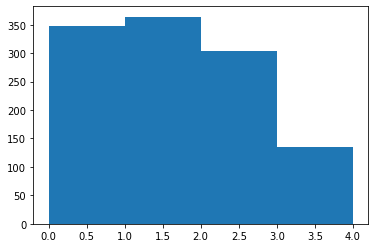

In [64]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [i for i in range (5)])

In [49]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.580539,0.075733,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.879629,0.879629,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.483104,0.483104,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-3.599510,0.026610,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.967272,0.967272,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.888851,0.888851,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.925709,0.925709,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.723768,0.723768,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.993048,0.993048,0.0,1.0,MAXIMIZE


In [66]:
synth=[]
for i in range (0,5):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part[:350-orig_size]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

,age,sex,bmi,children,smoker,region,charges
804,37,female,34.083364,2,no,northeast,2
610,51,male,20.859304,1,no,southwest,1
1083,36,female,32.001972,1,no,southwest,2
442,50,male,31.047267,0,yes,northwest,2
917,31,male,32.463058,2,yes,northeast,1
...,...,...,...,...,...,...,...
190,19,male,40.530477,2,no,southwest,1
1478,33,female,36.645573,0,yes,southeast,3
840,38,female,22.690703,0,no,northwest,1
384,34,male,18.834187,1,no,northwest,2


In [67]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.6347639275008218

In [68]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6673986563819909


In [69]:
print(max(scores))
print(min(scores))

0.6673986563819909
0.46546722428693765


In [54]:
model.save('best_copula.pkl')

In [70]:
synth.to_csv("ins_synth_CTGAN_CF.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [71]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_CTGAN_CF.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [72]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,1
336,60,male,25.740000,0,no,southeast,1
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
831,20,female,36.884460,2,no,northeast,3
832,19,male,31.716874,4,no,southeast,3
833,31,female,36.170954,0,no,northeast,3
834,57,female,30.103751,2,yes,southwest,3


In [73]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1638, 7)
Testing size (real: (536, 7)


(array([350., 714., 350., 224.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

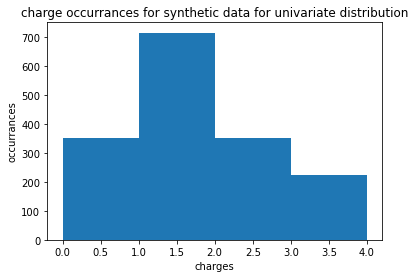

In [76]:
#plt.hist(synth_data["charges"], group)
total=len(mixed["charges"])
plt.title("charge occurrances for synthetic data for univariate distribution")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(mixed["charges"], [i for i in range (5)])

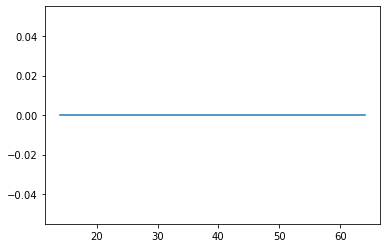

In [77]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total2=len(ins_data["charges"][ins_data["charges"]>13000])
ans2 = []
for i in range(14,65):
    num=len(ins_data["charges"][ins_data["charges"]<(i+1)*1000][ins_data["charges"]>=i*1000])
    ans2.append(num/total)
ans2=np.array(ans2)
plt.plot(range(14,65),ans2)
plt.show()

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [78]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

(25      1
 336     1
 47      0
 106     0
 1269    1
        ..
 831     3
 832     3
 833     3
 834     3
 835     3
 Name: charges, Length: 1638, dtype: int64,
 {'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 Pip

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [79]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5449,0.7043,0.4764,0.5312,0.5199,0.3249,0.3345,0.2140
nb,Naive Bayes,0.5437,0.6980,0.4718,0.5278,0.5199,0.3275,0.3347,0.0180
lda,Linear Discriminant Analysis,0.5351,0.6989,0.4580,0.5265,0.5064,0.3031,0.3142,0.0150
lr,Logistic Regression,0.5296,0.6983,0.4425,0.5187,0.5021,0.2907,0.3019,0.9150
lightgbm,Light Gradient Boosting Machine,0.5156,0.6858,0.4528,0.5003,0.4999,0.2898,0.2942,0.0970
rf,Random Forest Classifier,0.5126,0.6804,0.4543,0.4953,0.4966,0.2837,0.2874,0.1790
ada,Ada Boost Classifier,0.5101,0.6585,0.4221,0.4945,0.4762,0.2646,0.2785,0.0470
ridge,Ridge Classifier,0.5077,0.0000,0.4055,0.5064,0.4725,0.2477,0.2639,0.0160
qda,Quadratic Discriminant Analysis,0.4710,0.6512,0.4170,0.4663,0.4573,0.2342,0.2380,0.0160
et,Extra Trees Classifier,0.4595,0.6560,0.4068,0.4511,0.4515,0.2142,0.2156,0.1570


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3450, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [63]:
par = create_model("par")

ValueError: Estimator par not available. Please see docstring for list of available estimators.

In [ ]:
final_gbc = finalize_model(huber)

**NOTE**: I haven't further explored the model e.g. feature importance as the purpose of this project was to focus on synthetic data generation and a streamlit app.

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [ ]:
# Model (save)
save_model(final_gbc, "final_gbc")

# Preparation steps (get + save)
prep = get_config("prep_pipe")
joblib.dump(prep, 'prep_pipe.pkl', compress = 1)

# Preprocessed data (get + save)
get_config("X").to_csv("preprocssed_data.csv", index = False)

# **Streamlit app**
The final output of this was a `streamlit` app to allow single predictions w/reason plots or multi predictions from an uploaded csv (see `README.md` and `app.py`).

# **Conclusion**
I think that synthetic data generation can be a powerful tool especially in situations when further data collection cannot be performed in the near term. Fine tuning hyperparameters is great to have but more data and feature engineering are still superior.

In [ ]:
# any random test
import random
# give a data of 20% 0-100, 40% 100-200, 30% 200-300,10% 300-400, 
small=[[100*random.random()] for _ in range (400)]
medium=[[100+100*random.random()] for _ in range (800)]
large=[[200+100*random.random()] for _ in range (600)]
extralarge=[[300+100*random.random()] for _ in range (200)]
mix=small+medium+large+extralarge
random.shuffle(mix)
df = pd.DataFrame(mix, columns=["s"])
final_ans=[]
for _ in range (200):
    toy_ans = list()
    model = GaussianCopula()
    model.fit(df)
    synth = model.sample(num_rows = 2000)
    for i in range(4):
        num=len(synth["s"][synth["s"]<(i+1)*100][synth["s"]>=i*100])
        toy_ans.append(num/2000)
    final_ans.append(toy_ans)
final_ans

In [ ]:
plt.hist(np.array(mix),bins=np.array([10*i for i in range(41)]))

In [ ]:
arr=np.array(final_ans)
trans_arr=np.transpose(arr)
plt.hist(trans_arr[3],bins=np.array([i/500 for i in range (38,55)]))

In [ ]:
plt.hist(trans_arr[2],bins=np.array([i/500 for i in range (140,169)]))

In [ ]:
plt.hist(trans_arr[1],bins=np.array([i/500 for i in range (179,207)]))

In [ ]:
plt.hist(trans_arr[0],bins=np.array([i/500 for i in range (75,99)]))